# **SchNetPack Ensemble Calculator for Atomistic Simulations**

This tutorial demonstrates how to use SchNetPack’s ensemble calculator to predict atomic energies and forces with uncertainty estimation.

We’ll walk through the following examples:
- How to calculate ensemble-based uncertainty
- Structure relaxation using ensemble predictions and uncertainty
- Running molecular dynamics (MD) simulations with uncertainty

These tools are useful for identifying uncertain regions in simulation trajectories and making more informed decisions in atomistic modeling.


In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from ase import units
from ase.io import read
from ase.optimize.lbfgs import LBFGS
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin

from schnetpack.interfaces.ase_interface import SpkEnsembleCalculator, AbsoluteUncertainty, RelativeUncertainty
import schnetpack.transform as trn
from schnetpack.datasets import MD17


np.random.seed(42)

## Ensemble Interface to ASE

We specify a list of SchNet models trained on ethanol structures from the rMD17 dataset. These models constitute the **ensemble**, which will be used to serve as a testbed for SchNetPack’s ensemble-enabled `SpkEnsembleCalculator`.

In [2]:
model_path_list = ['../../tests/testdata/md_ethanol.model',
                   '../../tests/testdata/md_ethanol_2.model']

### ⚖️ Creating an Ensemble Calculator with Uncertainty Quantification

In this section, we instantiate two different uncertainty estimators:
- `AbsoluteUncertainty` calculates raw standard deviation values.
- `RelativeUncertainty` gives uncertainty as a fraction of the mean, which helps when comparing predictions on different scales.

Both uncertainty methods are bundled together in `SpkEnsembleCalculator`. This lets us evaluate uncertainty in multiple ways for the same prediction run, giving a more complete picture of model confidence.

Finally, we create the `SpkEnsembleCalculator`, which uses multiple trained models to make predictions. It also estimates uncertainty using the methods we provided. This calculator will act just like a regular ASE calculator but with built-in support for ensemble averaging and uncertainty tracking.

Note that you can also define custom uncertainty methods and pass them to the `SpkEnsembleCalculator`.

In [3]:
uncertainty_abs = AbsoluteUncertainty(energy_weight=0.5,force_weight=1.0)
uncertainty_rel = RelativeUncertainty(energy_weight=1.0, force_weight=2.0)

uncertainty = [uncertainty_abs, uncertainty_rel]

ensemble_calculator = SpkEnsembleCalculator(
    models=model_path_list,
    neighbor_list=trn.ASENeighborList(cutoff=5.0),
    energy_key=MD17.energy,
    force_key=MD17.forces,
    energy_unit="kcal/mol",
    position_unit="Ang",
    uncertainty_fn=uncertainty)

INFO:schnetpack.interfaces.ase_interface:Loading model from ../../tests/testdata/md_ethanol.model
/home/jonas/Documents/schnetpack/src/schnetpack/utils/compatibility.py:41: UserWarning: Model was saved without version information. Conversion to current version may fail.
  warnings.warn(
INFO:schnetpack.interfaces.ase_interface:Loading model from ../../tests/testdata/md_ethanol_2.model


Assign the ensemble calculator `ensemble_calculator` to the atoms object

In [4]:
#load data into atoms object
atoms = read('../../tests/testdata/md_ethanol.xyz', index=0)
# specify atoms calculator
atoms.calc = ensemble_calculator

 🔮 Prediction Output:
- ⚡ Energy: Total potential energy of the atomic system.
- 🔧 Forces: Atomic forces for optimization or molecular dynamics.
- 📊 Uncertainty: Estimation of model prediction uncertainty from the ensemble.

In [5]:
print("Prediction:")
print("energy:", atoms.get_total_energy())
print("forces:", atoms.get_forces())
print("uncertainty:", ensemble_calculator.get_uncertainty(atoms))

Prediction:
energy: -4212.739181765813
forces: [[ 0.53237236  0.05762891  0.05992955]
 [-0.46424631 -0.10478415 -0.10571388]
 [-0.1861552   0.41584553  0.40641014]
 [-0.26005711 -0.58657492  0.17410095]
 [-0.25510493  0.16400482 -0.5916369 ]
 [ 0.25508203 -0.1119127   0.78546825]
 [ 0.26097356  0.78140218 -0.12589313]
 [-1.19867554 -0.56872707 -0.56520089]
 [ 1.31581126 -0.04688257 -0.03746415]]
uncertainty: {'AbsoluteUncertainty': 1.0024158519507491, 'RelativeUncertainty': 0.20173344509616792}


# Structure Optimization

🏗️ **Distort molecular structure:**
- A small random disturbance is added to the atomic positions.
- This simulates a noisy or slightly perturbed structure, which helps us test how sensitive the ensemble model is to input changes.
- It also makes the uncertainty values more meaningful by introducing some variability.

In [6]:
# distort the structure
atoms.positions += np.random.normal(0, 0.2, atoms.positions.shape)

⚙️ **Set Up Optimization:**
- 🧑‍🔬 **Optimizer**: We set up the LBFGS optimizer, which is a gradient-based method used to minimize the energy of the atomic system.
- 🔬 **Calculator**: Assign the ensemble calculator to the atoms object, this connects the prediction engine (our ensemble of models) to the atomic system.

In [7]:
optimizer = LBFGS(atoms)
atoms.calc = ensemble_calculator

🔄 **Optimization Loop with Uncertainty Tracking:**
- 🧑‍🔬 **Optimizer**: Run the optimization using the LBFGS algorithm with a force tolerance of 0.01 and a maximum of 100 steps.
- 📊 **Uncertainty Tracking**: After each optimization step, the uncertainty of the energy prediction is appended to the `uncertainties` list, providing insight into model confidence during the process.

In [8]:
uncertainties = []

for _ in optimizer.irun(fmax=0.05, steps=300):
    uncertainties.append(ensemble_calculator.get_uncertainty(atoms))

       Step     Time          Energy          fmax
LBFGS:    0 13:25:04    -4208.226857        5.569111
LBFGS:    1 13:25:04    -4209.231171        6.033072
LBFGS:    2 13:25:04    -4209.638432        7.205857
LBFGS:    3 13:25:04    -4210.573076        5.259102
LBFGS:    4 13:25:04    -4210.647703        8.318875
LBFGS:    5 13:25:04    -4211.375595        2.674026
LBFGS:    6 13:25:04    -4211.500988        1.290127
LBFGS:    7 13:25:04    -4211.639122        0.876576
LBFGS:    8 13:25:04    -4211.792305        0.965818
LBFGS:    9 13:25:04    -4211.827040        0.850569
LBFGS:   10 13:25:04    -4211.961150        2.239300
LBFGS:   11 13:25:04    -4211.922942        3.411105
LBFGS:   12 13:25:04    -4212.155089        3.355407
LBFGS:   13 13:25:04    -4212.320584        3.220980
LBFGS:   14 13:25:04    -4212.159499        7.519482
LBFGS:   15 13:25:04    -4212.648440        1.729246
LBFGS:   16 13:25:04    -4212.708799        0.979791
LBFGS:   17 13:25:04    -4212.743737        0.36

Since we're using an ensemble of models, we can now estimate the uncertainty in our predictions during the optimization process:
- **Absolute** and **Relative Uncertainty** values are extracted from the optimization steps.
- Plot both **absolute** and **relative** uncertainties against the optimization steps to visualize how uncertainty changes during the process.

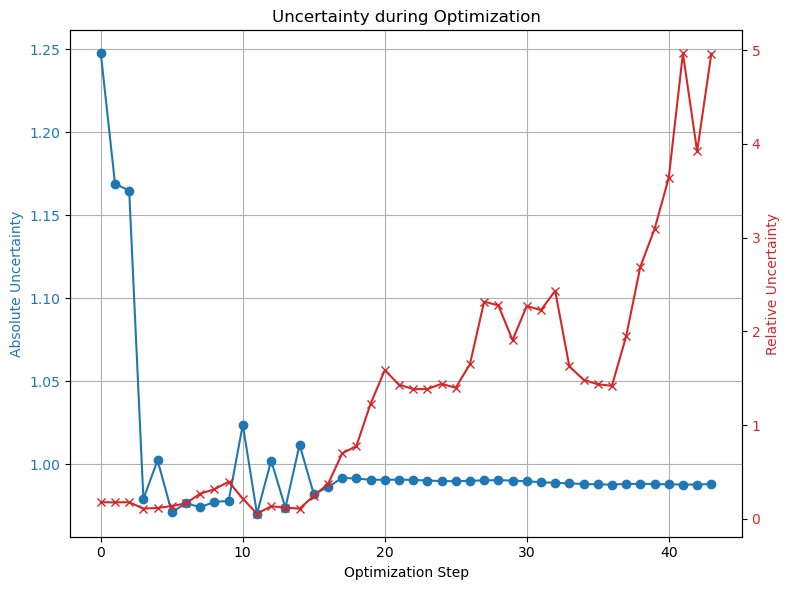

In [9]:
# Extract individual uncertainty types
abs_vals = [d["AbsoluteUncertainty"] for d in uncertainties]
rel_vals = [d["RelativeUncertainty"] for d in uncertainties]
steps = list(range(len(uncertainties)))

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot absolute uncertainty on left y-axis
ax1.plot(steps, abs_vals, label="Absolute Uncertainty", marker='o', color='tab:blue')
ax1.set_xlabel("Optimization Step")
ax1.set_ylabel("Absolute Uncertainty", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create second y-axis for relative uncertainty
ax2 = ax1.twinx()
ax2.plot(steps, rel_vals, label="Relative Uncertainty", marker='x', color='tab:red')
ax2.set_ylabel("Relative Uncertainty", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout
plt.title("Uncertainty during Optimization")
fig.tight_layout()
plt.show()


While the absolute uncertainty rapidly decreases and remains consistently low and stable thereafter, the relative uncertainty increases as the structure optimization converges. This rise in relative uncertainty is due to the diminishing force magnitudes: although the prediction uncertainty stays nearly constant, the mean predicted values become very small, leading to a larger ratio between uncertainty and prediction.

# Molecular Dynamics With Increasing Temperature

We now investigate the behavior of the uncertainty measure during a MD simulation. To this end, we perform a simulation in the canonical ensemble (NVT), gradually increasing the temperature of the heat bath throughout the run. As the temperature rises, we expect larger deviations of the molecular structure from equilibrium configurations. Consequently, the system is more likely to sample structures that lie outside the training distribution of the machine learning force field. This effect is reflected in the absolute uncertainty measure, which increases with temperature.

In this setup, we use only absolute uncertainty to measure how much the model predictions vary across the ensemble:

🔎 **Note**: The `uncertainty_fn` can be passed as either a **single** uncertainty function or as a **list** of uncertainty functions.


In [10]:
uncertainty_abs = AbsoluteUncertainty(energy_weight=0.5,force_weight=1.0)

abs_ensemble_calculator = SpkEnsembleCalculator(
    models=model_path_list,
    neighbor_list=trn.ASENeighborList(cutoff=5.0),
    energy_key=MD17.energy,
    force_key=MD17.forces,
    energy_unit="kcal/mol",
    position_unit="Ang",
    uncertainty_fn=uncertainty_abs)

INFO:schnetpack.interfaces.ase_interface:Loading model from ../../tests/testdata/md_ethanol.model
INFO:schnetpack.interfaces.ase_interface:Loading model from ../../tests/testdata/md_ethanol_2.model


In [11]:
target_temperatures = [_ for _ in range(50, 1000, 100)]  
n_steps = 1000          
sampling_interval = 10  
step_size = 0.5   

# setting up initial atoms
atoms = read('../../tests/testdata/md_ethanol.xyz', index=0)
atoms.calc = abs_ensemble_calculator

MaxwellBoltzmannDistribution(atoms, temperature_K=target_temperatures[0])

ats_traj = []
uncertainties = []
temp = []

for target_temperature in target_temperatures:
    print(f"Temp: {target_temperature:.2f} K")
    for step in tqdm(range(n_steps // sampling_interval)):
    
        dyn = Langevin(
            atoms, 
            timestep=step_size * units.fs, 
            temperature_K=target_temperature,
            friction=0.01 / units.fs
        )
    
        dyn.run(sampling_interval)
    
        temp.append(atoms.get_temperature())
        uncertainties.append(abs_ensemble_calculator.get_uncertainty(atoms))
        
        ats_traj.append(atoms.copy())

Temp: 50.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.69it/s]


Temp: 150.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


Temp: 250.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.92it/s]


Temp: 350.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s]


Temp: 450.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


Temp: 550.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


Temp: 650.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]


Temp: 750.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.35it/s]


Temp: 850.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Temp: 950.00 K


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.91it/s]


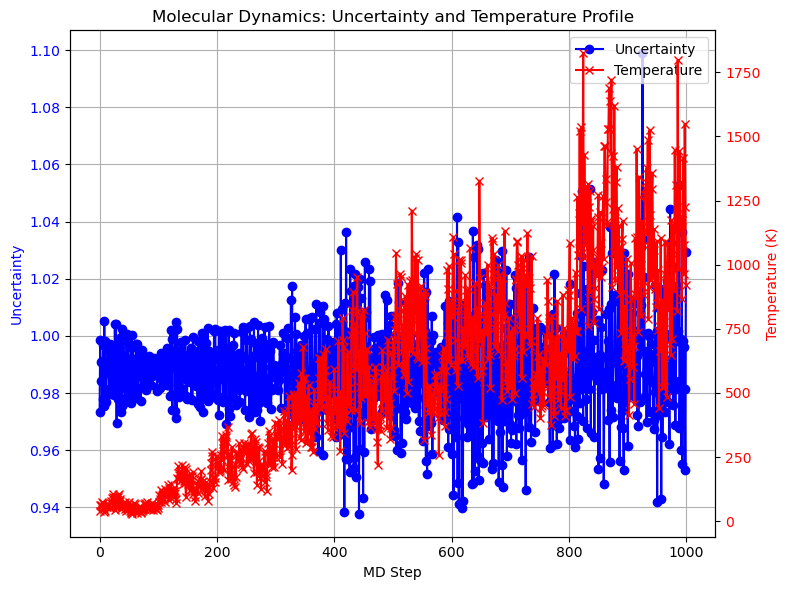

In [24]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(uncertainties, marker='o', color='blue', label='Uncertainty')
ax1.set_xlabel("MD Step")
ax1.set_ylabel("Uncertainty", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(temp, marker='x', color='red', label='Temperature')
ax2.set_ylabel("Temperature (K)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Molecular Dynamics: Uncertainty and Temperature Profile")
ax1.grid(True)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()

Let's visualize the MD trajectory of the structure to make sure that nothing went wrong

In [26]:
from ase.visualize import view
view(ats_traj)

<Popen: returncode: None args: ['/home/jonas/miniforge3/envs/schnetpack/bin/...>